In [1]:
#necessary libraries
!pip install imbalanced-learn scikit-learn seaborn --quiet

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import re
import random
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading dataset from file
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name)

#dataset structure
print("Dataset Columns:", df.columns)
print(df.head())

Saving Book1.xlsx to Book1.xlsx
Dataset Columns: Index(['Text', 'moderately toxic 0', 'sever toxic 1', 'threat 2', 'neutral  3',
       'class'],
      dtype='object')
                                                Text  moderately toxic 0  \
0  নোয়াখাইল্লা বিস্কুট। এটা নোয়াখাইল্লা লোকেরাই শ...                 1.0   
1         ম্যাচ আবার হবে? ফিক্সিং ধরা খেল মুম্বাই।\n                 0.0   
2                                    তুই একটা কুকুর                  1.0   
3                                   তুই একটা বেয়াদব!                 1.0   
4                             আপনাকে সুন্দর লাগছে 🫶🫶                 0.0   

   sever toxic 1  threat 2  neutral  3  class  
0            0.0       0.0         0.0    0.0  
1            1.0       0.0         0.0    1.0  
2            0.0       0.0         0.0    0.0  
3            0.0       0.0         0.0    0.0  
4            0.0       0.0         1.0    3.0  


In [4]:
# Keeping only 'Text' and 'class' columns
df = df[['Text', 'class']].copy()

# Handling missing values: Drop rows where 'Text' is NaN
df.dropna(subset=['Text'], inplace=True)

# Replacing numeric values in the 'class' column with corresponding labels
class_mapping = {
    0.0: "moderately toxic",
    1.0: "sever toxic",
    2.0: "threat",
    3.0: "neutral"
}
df['class'] = df['class'].map(class_mapping)

#cleaned dataset
print("Cleaned Dataset:")
print(df.head())


Cleaned Dataset:
                                                Text             class
0  নোয়াখাইল্লা বিস্কুট। এটা নোয়াখাইল্লা লোকেরাই শ...  moderately toxic
1         ম্যাচ আবার হবে? ফিক্সিং ধরা খেল মুম্বাই।\n       sever toxic
2                                    তুই একটা কুকুর   moderately toxic
3                                   তুই একটা বেয়াদব!  moderately toxic
4                             আপনাকে সুন্দর লাগছে 🫶🫶           neutral


In [5]:
# Cleaning function for text comments
def process_comments(comment):
    if not isinstance(comment, str):
        return ""
    comment = re.sub('[^\u0980-\u09FF]', ' ', comment)
    comment = re.sub('[?.`*^()!\u09E6-\u09EF;!,&%\'@#$><A-Za-z0-9=./\'\"_]', '', comment)
    comment = re.sub(r'(\W)(?=\1)', '', comment)
    comment = re.sub(r'https?://.*[\r\n]*', '', comment, flags=re.MULTILINE)
    return comment

# Clean the text column
df['Cleaned'] = df['Text'].apply(process_comments)

In [6]:
# Generating stopwords from the dataset
all_words = []
df['Cleaned'].dropna().apply(lambda x: all_words.extend(x.split()))
word_counts = Counter(all_words)
stopword_threshold = 50
generated_stopwords = [word for word, count in word_counts.items() if count > stopword_threshold]

#remove stopwords
def stopword_removal(comment, stopwords):
    if not isinstance(comment, str):
        return ""
    words = comment.split()
    filtered_words = [word.strip() for word in words if word not in stopwords]
    return " ".join(filtered_words)

# stopword removal
df['Cleaned'] = df['Cleaned'].apply(lambda x: stopword_removal(x, generated_stopwords))


In [7]:
# Drop rows with empty Cleaned comments
df['length'] = df['Cleaned'].apply(lambda x: len(x.split()))
df = df[df['length'] > 0].reset_index(drop=True)

# Encode class labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['class'])
print("Class names:", le.classes_)

Class names: ['moderately toxic' 'neutral' 'sever toxic' 'threat']


In [8]:
# TF-IDF features
def calc_gram_tfidf(reviews, ngram_range):
    tfidf = TfidfVectorizer(ngram_range=ngram_range, use_idf=True, tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(reviews)
    return tfidf, X

# TF-IDF for unigrams and bigrams
tfidf, features = calc_gram_tfidf(df['Cleaned'], (1, 2))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, df['Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42, stratify=labels_resampled)

Training and evaluating model: Logistic Regression


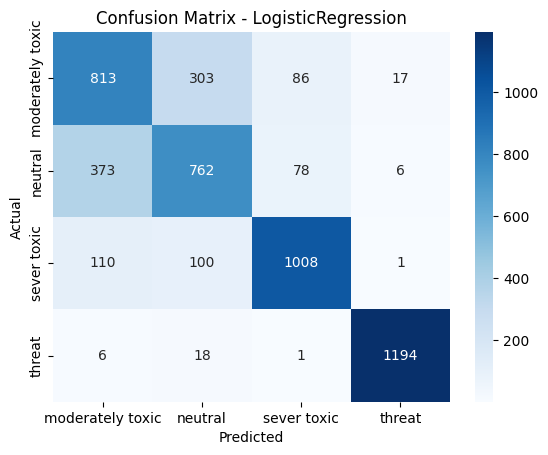

Training and evaluating model: Naive Bayes


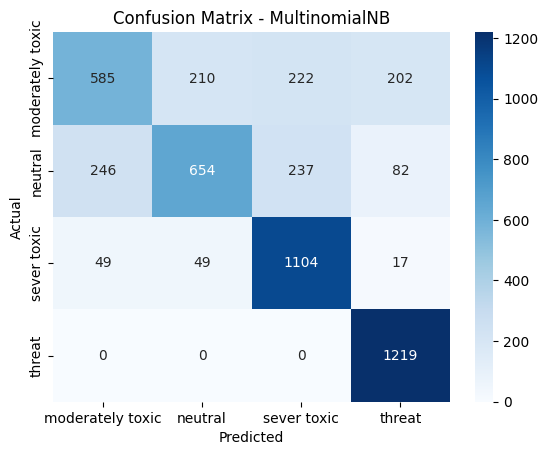

Training and evaluating model: KNN


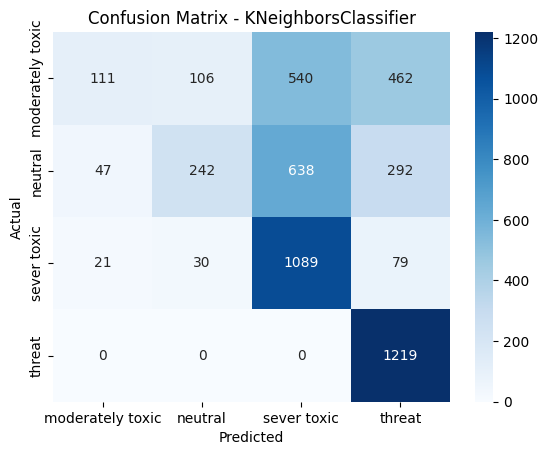

In [10]:
#  machine learning models
def model_defination():
    return {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced'),
        'Naive Bayes': MultinomialNB(alpha=1.0),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }

# Evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    return {
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions, average='weighted'),
        'Recall': recall_score(y_test, predictions, average='weighted'),
        'F1 Score': f1_score(y_test, predictions, average='weighted')
    }

# Train and evaluate models
models = model_defination()
performance = {}
trained_models = {}
for name, model in models.items():
    print(f"Training and evaluating model: {name}")
    trained_models[name] = model.fit(X_train, y_train)  # Store trained models for later use
    performance[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

In [11]:
# performance metrics to a DataFrame
performance_df = pd.DataFrame(performance).T
performance_df = performance_df.sort_values(by='Accuracy', ascending=False)

# performance results
print(performance_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.774610   0.777045  0.774610  0.775539
Naive Bayes          0.730517   0.722350  0.730517  0.713674
KNN                  0.545734   0.583687  0.545734  0.457997


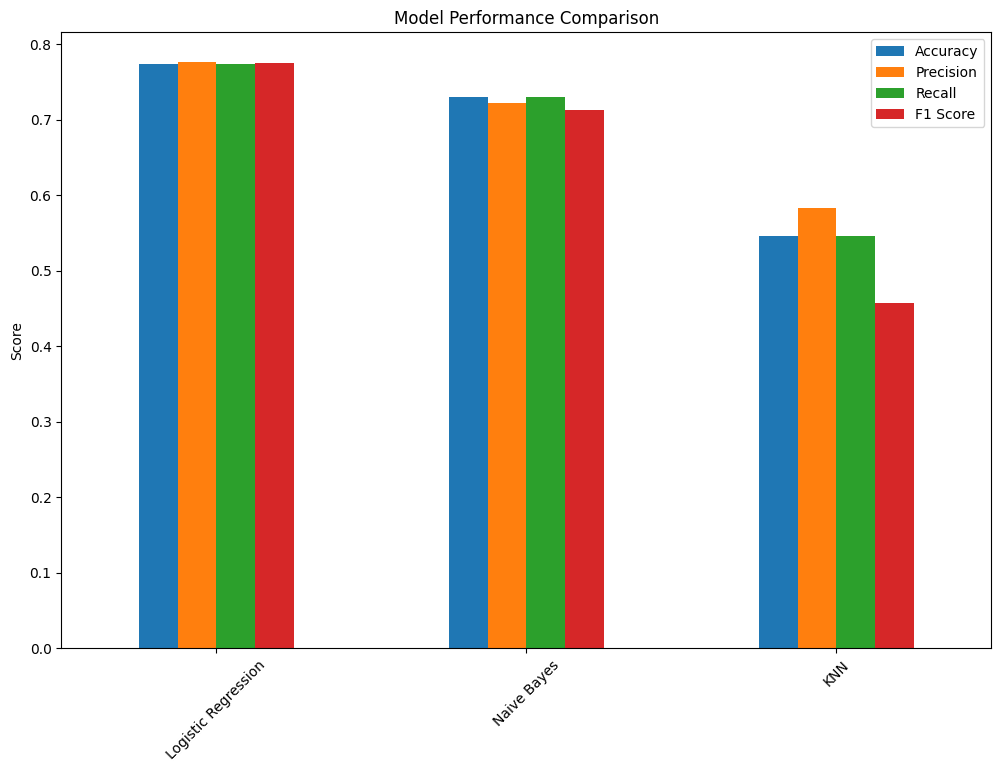

In [12]:
# Visualize performance
performance_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [13]:
#detailed classification report for best model
best_model_name = performance_df.index[0]
best_model = trained_models[best_model_name]
y_pred = best_model.predict(X_test)

# Classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report for Logistic Regression:
                  precision    recall  f1-score   support

moderately toxic       0.62      0.67      0.64      1219
         neutral       0.64      0.63      0.63      1219
     sever toxic       0.86      0.83      0.84      1219
          threat       0.98      0.98      0.98      1219

        accuracy                           0.77      4876
       macro avg       0.78      0.77      0.78      4876
    weighted avg       0.78      0.77      0.78      4876



In [14]:
def display_predictions_and_validate(
    model, X_test, y_test, original_df, label_encoder, num_samples=2, confidence_threshold=0.0
):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)
    print("Predictions and probabilities")


    # Correct and incorrect predictions storage
    correct_predictions = []
    incorrect_predictions = []

    for i, test_index in enumerate(y_test.index):
        if test_index not in original_df.index:

            continue

        # Fetch data from DataFrame
        row = original_df.loc[test_index]
        sample_text = row.get('Text', "N/A")  # Default to "N/A" if 'Text' column is missing
        actual_label = row.get('class', "Unknown")  # Default to "Unknown" if 'class' column is missing

        # Decode predictions and confidence
        predicted_label = label_encoder.inverse_transform([y_pred[i]])[0]
        confidence = max(y_pred_prob[i])



        # Store predictions
        if confidence >= confidence_threshold:
            if y_test.iloc[i] == y_pred[i]:
                correct_predictions.append((sample_text, actual_label, predicted_label, confidence))
            else:
                incorrect_predictions.append((sample_text, actual_label, predicted_label, confidence))

    # --- Filtered Prediction Statistics ---
    total_correct = len(correct_predictions)
    total_incorrect = len(incorrect_predictions)
    accuracy = total_correct / (total_correct + total_incorrect) if (total_correct + total_incorrect) > 0 else 0

    print("\n--- Filtered Prediction Statistics ---")
    print(f"Total Correct Predictions: {total_correct}")
    print(f"Total Incorrect Predictions: {total_incorrect}")

    # --- Class-Wise Accuracy ---
    class_accuracies = {}
    for class_index in y_test.unique():
        actual_indices = (y_test == class_index)
        correct_class_predictions = sum((y_pred[actual_indices] == y_test[actual_indices]))
        class_name = label_encoder.inverse_transform([class_index])[0]
        class_accuracies[class_name] = correct_class_predictions / sum(actual_indices)

    print("\nClass-Wise Accuracy:")
    for class_name, acc in class_accuracies.items():
        print(f"  {class_name}: {acc:.2%}")
    print("-" * 50)

    # --- Sample Predictions ---
    sampled_correct = random.sample(correct_predictions, min(len(correct_predictions), num_samples))
    sampled_incorrect = random.sample(incorrect_predictions, min(len(incorrect_predictions), num_samples))

    # --- Correct Predictions ---
    print("\n--- Correct Predictions ---")
    for text, actual, predicted, conf in sampled_correct:
        print(f"Text: {text}\nActual Label: {actual}\nPredicted Label: {predicted} (Confidence: {conf:.2f})\n{'-'*50}")

    # --- Incorrect Predictions ---
    print("\n--- Incorrect Predictions ---")
    for text, actual, predicted, conf in sampled_incorrect:
        print(f"Text: {text}\nActual Label: {actual}\nPredicted Label: {predicted} (Confidence: {conf:.2f})\n{'-'*50}")

best_model_name = performance_df.index[0]  # best model name based on performance
best_model = trained_models[best_model_name]  # Fetching the corresponding trained model

# Call the function
display_predictions_and_validate(
    model=best_model,
    X_test=X_test,
    y_test=y_test,
    original_df=df,
    label_encoder=le,
    num_samples=1,  # Number of samples to display
    confidence_threshold=0.6  # Confidence threshold for filtering predictions
)


Predictions and probabilities

--- Filtered Prediction Statistics ---
Total Correct Predictions: 222
Total Incorrect Predictions: 27

Class-Wise Accuracy:
  neutral: 62.51%
  moderately toxic: 66.69%
  threat: 97.95%
  sever toxic: 82.69%
--------------------------------------------------

--- Correct Predictions ---
Text: ইয়েস ক্ষতি হবে
Actual Label: sever toxic
Predicted Label: sever toxic (Confidence: 0.68)
--------------------------------------------------

--- Incorrect Predictions ---
Text: অনেক অনেক ভালো ছবি,,, পরিচালক কে ধন্যবাদ,,, 🏄🏂
Actual Label: neutral
Predicted Label: moderately toxic (Confidence: 0.86)
--------------------------------------------------


In [15]:
def test_user_input_sentence(model, original_df, le, tfidf, preprocess_pipeline):
    """
    Prompt the user to input a Bengali sentence, test it with the trained model,
    and display the predicted class.

    Args:
        model: Trained model.
        original_df: Original DataFrame (not used here but kept for consistency).
        le: Label encoder.
        tfidf: Fitted TF-IDF vectorizer.
        preprocess_pipeline: Function for text preprocessing.
    """
    while True:
        # Prompt user for input
        user_input = input("\nEnter a Bengali sentence for prediction (or type 'exit' to quit): ").strip()

        # Exit condition
        if user_input.lower() == 'exit':
            print("Exiting... Thank you!")
            break

        if not user_input:
            print("Empty input. Please provide a valid sentence.")
            continue

        # Preprocess the input sentence
        cleaned_sentence = preprocess_pipeline(user_input)

        # Transform the sentence using the fitted TF-IDF vectorizer
        sentence_features = tfidf.transform([cleaned_sentence])

        # Predict the label
        predicted_class = model.predict(sentence_features)
        predicted_label = le.inverse_transform(predicted_class)[0]
        predicted_prob = model.predict_proba(sentence_features)
        confidence = max(predicted_prob[0])

        # Display prediction
        print("\n--- Prediction Result ---")
        print(f"Input Sentence: {user_input}")
        print(f"Predicted Class: {predicted_label}")
        print(f"Confidence Score: {confidence:.2f}")
        print("-" * 60)

# Preprocessing pipeline
def preprocess_pipeline(text):
    cleaned_text = process_comments(text)  # Your text cleaning function
    cleaned_text = stopword_removal(cleaned_text, generated_stopwords)  # Stopword removal
    return cleaned_text

# Call the function to allow user input
test_user_input_sentence(best_model, df, le, tfidf, preprocess_pipeline)



Enter a Bengali sentence for prediction (or type 'exit' to quit): ময়ুরির দুধ গুলা দেখিনি অনেক দিন দরে

--- Prediction Result ---
Input Sentence: ময়ুরির দুধ গুলা দেখিনি অনেক দিন দরে
Predicted Class: sever toxic
Confidence Score: 0.32
------------------------------------------------------------

Enter a Bengali sentence for prediction (or type 'exit' to quit): exit
Exiting... Thank you!
